In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from numpy.random import seed
seed(123)
#from tensorflow import set_random_seed
#set_random_seed(123)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio
import matplotlib.pyplot as plt
%matplotlib inline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lyft-udacity-challenge/datab/dataB/CameraRGB/02_02_222.png
/kaggle/input/lyft-udacity-challenge/datab/dataB/CameraRGB/F4-82.png
/kaggle/input/lyft-udacity-challenge/datab/dataB/CameraRGB/02_02_112.png
/kaggle/input/lyft-udacity-challenge/datab/dataB/CameraRGB/F7-22.png
/kaggle/input/lyft-udacity-challenge/datab/dataB/CameraRGB/F66-52.png
/kaggle/input/lyft-udacity-challenge/datab/dataB/CameraRGB/04_00_243.png
/kaggle/input/lyft-udacity-challenge/datab/dataB/CameraRGB/06_00_143.png
/kaggle/input/lyft-udacity-challenge/datab/dataB/CameraRGB/F9-23.png
/kaggle/input/lyft-udacity-challenge/datab/dataB/CameraRGB/04_00_152.png
/kaggle/input/lyft-udacity-challenge/datab/dataB/CameraRGB/05_00_232.png
/kaggle/input/lyft-udacity-challenge/datab/dataB/CameraRGB/F68-23.png
/kaggle/input/lyft-udacity-challenge/datab/dataB/CameraRGB/F9-83.png
/kaggle/input/lyft-udacity-challenge/datab/dataB/CameraRGB/08_00_153.png
/kaggle/input/lyft-udacity-challenge/datab/dataB/CameraRGB/09_00_052.png


In [2]:
image_path = '../input/lyft-udacity-challenge/dataA/dataA/CameraRGB/'
mask_path = '../input/lyft-udacity-challenge/dataA/dataA/CameraSeg/'
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

Pregled slike i njene segmentacije

Text(0.5, 1.0, 'Segmentation')

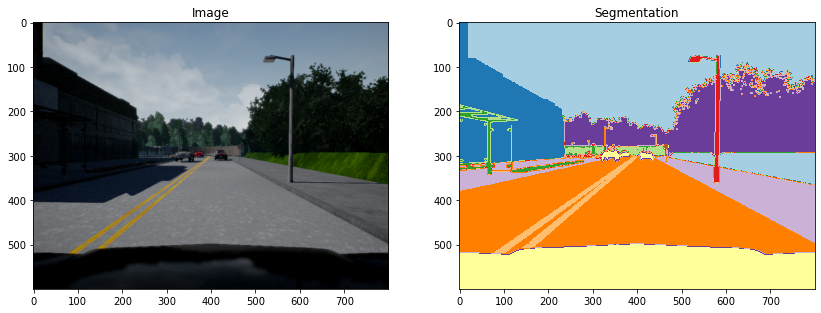

In [3]:
N = 1 #broj slike
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
mask = np.array([max(mask[i,j]) for i in range(mask.shape[0])
for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1,2,figsize=(14,10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask, cmap='Paired')
arr[1].set_title('Segmentation')

Segmentacija samo ceste

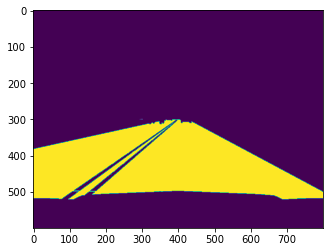

In [4]:
road = np.zeros((600, 800))
road[np.where(mask==7)[0], np.where(mask==7)[1]] = 1
plt.imshow(road)

In [5]:
from tqdm import tqdm

In [6]:
height, width = 600, 800
images = np.zeros((len(image_list), height, width, 3), dtype=np.int16)
masks = np.zeros((len(image_list), height, width, 1), dtype=np.int8)

for n in tqdm(range(len(image_list))):
    img = imageio.imread(image_list[n])
    
    mask = imageio.imread(mask_list[n])
    mask_road = np.zeros((600, 800, 1), dtype=np.int8)
    mask_road[np.where(mask==7)[0], np.where(mask==7)[1]]=1
    
    images[n] = img
    masks[n] = mask_road

100%|██████████| 1000/1000 [00:53<00:00, 18.79it/s]


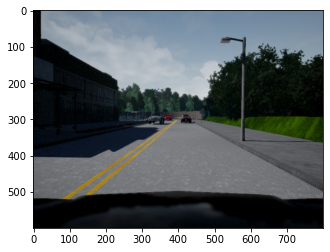

In [7]:
plt.imshow(images[1].reshape(600, 800, 3))

Kreiranje train,val i test dataseta iz random brojki

In [8]:
np.random.seed(123)
shuffle_ids = np.array([i for i in range(len(masks))])
np.random.shuffle(shuffle_ids)
train_ids = shuffle_ids[:int(len(masks)*0.8)]
val_ids = shuffle_ids[int(len(masks)*0.8):int(len(masks)*0.8+100)]
test_ids = shuffle_ids[int(len(masks)*0.8+100):]

In [9]:
train_images, train_masks = images[train_ids], masks[train_ids]
val_images, val_masks = images[val_ids], masks[val_ids]
test_images, test_masks = images[test_ids], masks[test_ids]

In [10]:
train_images.shape, val_images.shape, test_images.shape


((800, 600, 800, 3), (100, 600, 800, 3), (100, 600, 800, 3))

Buil U-Net

In [11]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

In [12]:
input_img = Input((height, width, 3), name='img')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)

u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c4)
u5 = concatenate([u5, c3])
c6 = Conv2D(32, (3, 3), activation='relu', padding='same') (u5)
c6 = Conv2D(32, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c2])
c7 = Conv2D(16, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(16, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c1])
c8 = Conv2D(8, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(8, (3, 3), activation='relu', padding='same') (c8)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c8)

model = Model(inputs=[input_img], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy') #, metrics=[mean_iou]) # The mean_iou metrics seens to leak train and test values...
model.summary()



Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 600, 800, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 600, 800, 8)  224         img[0][0]                        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 600, 800, 8)  584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 300, 400, 8)  0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [13]:
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('model-sdc-seg-v2.h5',verbose=1,save_best_only=True)
]

In [14]:
results = model.fit(train_images, train_masks, batch_size=16, epochs=100, callbacks=callbacks,validation_data=(val_images,val_masks))

Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 2.5519
Epoch 00001: val_loss improved from inf to 0.45102, saving model to model-sdc-seg-v2.h5
50/50 [==============================] - 17s 340ms/step - loss: 2.5519 - val_loss: 0.4510
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 0.4092
Epoch 00002: val_loss improved from 0.45102 to 0.40053, saving model to model-sdc-seg-v2.h5
50/50 [==============================] - 16s 323ms/step - loss: 0.4092 - val_loss: 0.4005
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 0.3609
Epoch 00003: val_loss improved from 0.40053 to 0.32976, saving model to model-sdc-seg-v2.h5
50/50 [==============================] - 16s 317ms/step - loss: 0.3609 - val_loss: 0.3298
Epoch 4/100
50/50 [==============================] - ETA: 0s - loss: 0.3115
Epoch 00004: val_loss improved from 0.32976 to 0.27065, saving model to model-sdc-seg-v2.h5
50/50 [==============================] - 16s 321ms/step - loss

In [15]:
model.save('final-road-seg-model-v2.h5')

Usporedba predikcije i stvarnog

Text(0.5, 1.0, 'Ground truth')

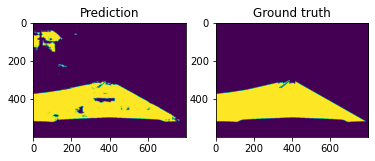

In [16]:
NUMBER = 0
my_preds=model.predict(np.expand_dims(test_images[NUMBER],0))
my_preds = my_preds.flatten()
my_preds = np.array([1 if i>=0.5 else 0 for i in my_preds])
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(my_preds.reshape(600,800))
ax[0].set_title('Prediction')
ax[1].imshow(test_masks[NUMBER].reshape(600,800))
ax[1].set_title('Ground truth')